In [9]:
from process_data import DataProcessor
import pandas as pd
from sklearn.preprocessing import RobustScaler
import torch

label = ['1_Gear oil temperature (°C)']

xtrain = pd.read_csv('data/single_turbine_data/X_train.csv')
xtest = pd.read_csv('data/single_turbine_data/X_test.csv')
ytrain = pd.read_csv('data/single_turbine_data/y_train.csv')
ytest = pd.read_csv('data/single_turbine_data/y_test.csv')

# combine train and test
X_train = pd.concat([xtrain, xtest])
y_train = pd.concat([ytrain, ytest])

processor = DataProcessor(X_train)
processor.process_all()
X_train = processor.data


original_cols = [
    # '1_Wind direction (°)',
    #    '1_Nacelle position (°)', 
       'avg_dir',
    #    '1_Power (kW)',
        '1_Wind speed (m/s)',
       '1_Front bearing temperature (°C)', '1_Rear bearing temperature (°C)',
    #    '1_Stator temperature 1 (°C)', 
    #    '1_Nacelle ambient temperature (°C)',
       '1_Nacelle temperature (°C)', 
    #    '1_Transformer temperature (°C)',
    #    '1_Generator bearing rear temperature (°C)',
       '1_Generator bearing front temperature (°C)', 
    #    '1_Temp. top box (°C)',
    #    '1_Hub temperature (°C)', 
       '1_Ambient temperature (converter) (°C)',
       '1_Rotor bearing temp (°C)', 
       '1_Transformer cell temperature (°C)', 
    #    '1_Generator RPM (RPM)',
       ]
leadsnlags = [
       '1_Wind direction (°)_lead6', 
       '1_Nacelle position (°)_lead3',
       '1_Power (kW)_lag6', 
       '1_Stator temperature 1 (°C)_lag1',
       '1_Nacelle ambient temperature (°C)_lead6',
       '1_Transformer temperature (°C)_lead6',
       '1_Generator bearing rear temperature (°C)_lag1',
       '1_Temp. top box (°C)_lag1', 
       '1_Hub temperature (°C)_lead6',
       '1_Ambient temperature (converter) (°C)_lead6',
       '1_Transformer cell temperature (°C)_lead6',
       '1_Generator RPM (RPM)_lead6']
extras = [
    # 'curtailed', 
    'offline',
    'historic_offline',
    ]

mean = [col for col in X_train.columns if 'mean' in col]
std = [col for col in X_train.columns if 'std' in col]
crest = [col for col in X_train.columns if 'crest' in col]
# kurt = [col for col in X_train.columns if 'kurt' in col]
change = [col for col in X_train.columns if 'change' in col]

cols = original_cols + extras + leadsnlags + mean + std + crest
X_train = X_train[cols]

data = pd.read_csv('data/evaluation_data/X_single_turbine.csv')

# concant the first 20 rows of X_train to the start of data
data = pd.concat([X_train.iloc[:20], data])

processor = DataProcessor(data)
processor.process_all()
data = processor.data
data = data[cols]

# drop the first 20 rows of data
data = data.iloc[20:]

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and wil

In [10]:
len(data.columns)

74

In [11]:
label = ['1_Gear oil temperature (°C)']
y_train = y_train[label]
scalerx = RobustScaler()
scalery = RobustScaler()
X_train_transformed = scalerx.fit_transform(X_train)
y_train = scalery.fit_transform(y_train)

data_transformed = scalerx.transform(data)

data_tensor = torch.FloatTensor(data_transformed)

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and wil

In [12]:
import torch.nn as nn

# Define Neural Network
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, input_dim*2)
        self.layer2 = nn.Linear(input_dim*2, input_dim*2)
        self.layer3 = nn.Linear(input_dim*2, output_dim)
        self.relu = nn.LeakyReLU(0.3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [13]:
import os
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import torch

# Initialize variables
combined_preds = []
path = 'models'

# Iterate through all models in the folder
for filename in os.listdir(path):
    if filename.endswith('v13.ckpt'):
        checkpoint_path = os.path.join(path, filename)
        state_dict = torch.load(checkpoint_path)
        model = MyModel(X_train.shape[1], y_train.shape[1])
        model.load_state_dict(state_dict['state_dict'])
        # Switch to evaluation mode
        model.eval()
        
        # Perform inference
        with torch.no_grad():
            y_pred = model(data_tensor)
        
        # Process predictions
        y_pred = y_pred.detach().numpy()
        y_pred = scalery.inverse_transform(y_pred)
        
        # Store predictions for later
        combined_preds.append(y_pred)

# Take the average of all predictions
combined_preds = np.array(combined_preds)
y_pred = np.mean(combined_preds, axis=0)

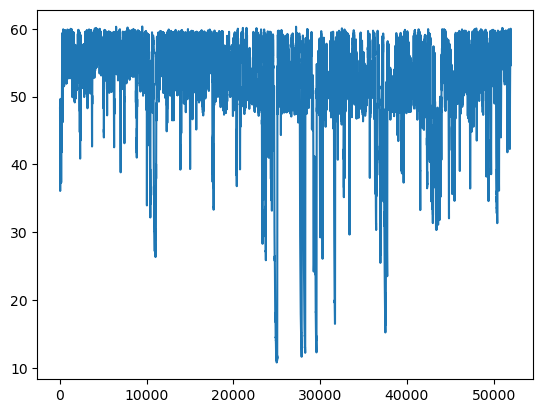

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(len(y_pred)), y_pred)

In [15]:
# create submission
submission = pd.read_csv('data/evaluation_data/y_template.csv')
submission['1_Gear oil temperature (°C)'] = y_pred
submission.to_csv('submission_jhyland_nn.csv', index=False)

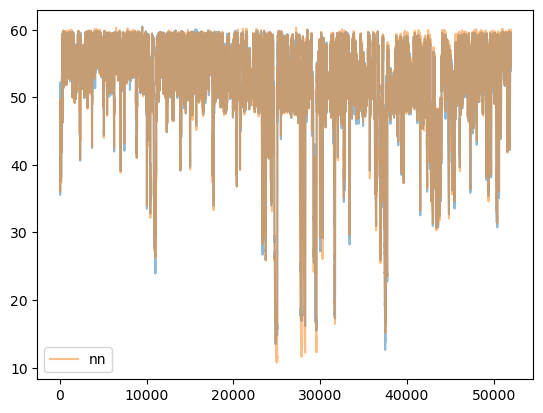

In [16]:
ag = pd.read_csv('submission_jhyland_ag.csv')

plt.plot(range(len(ag)), ag['1_Gear oil temperature (°C)'], alpha=0.5)
plt.plot(range(len(y_pred)), y_pred, alpha=0.5, label='nn')
plt.legend()

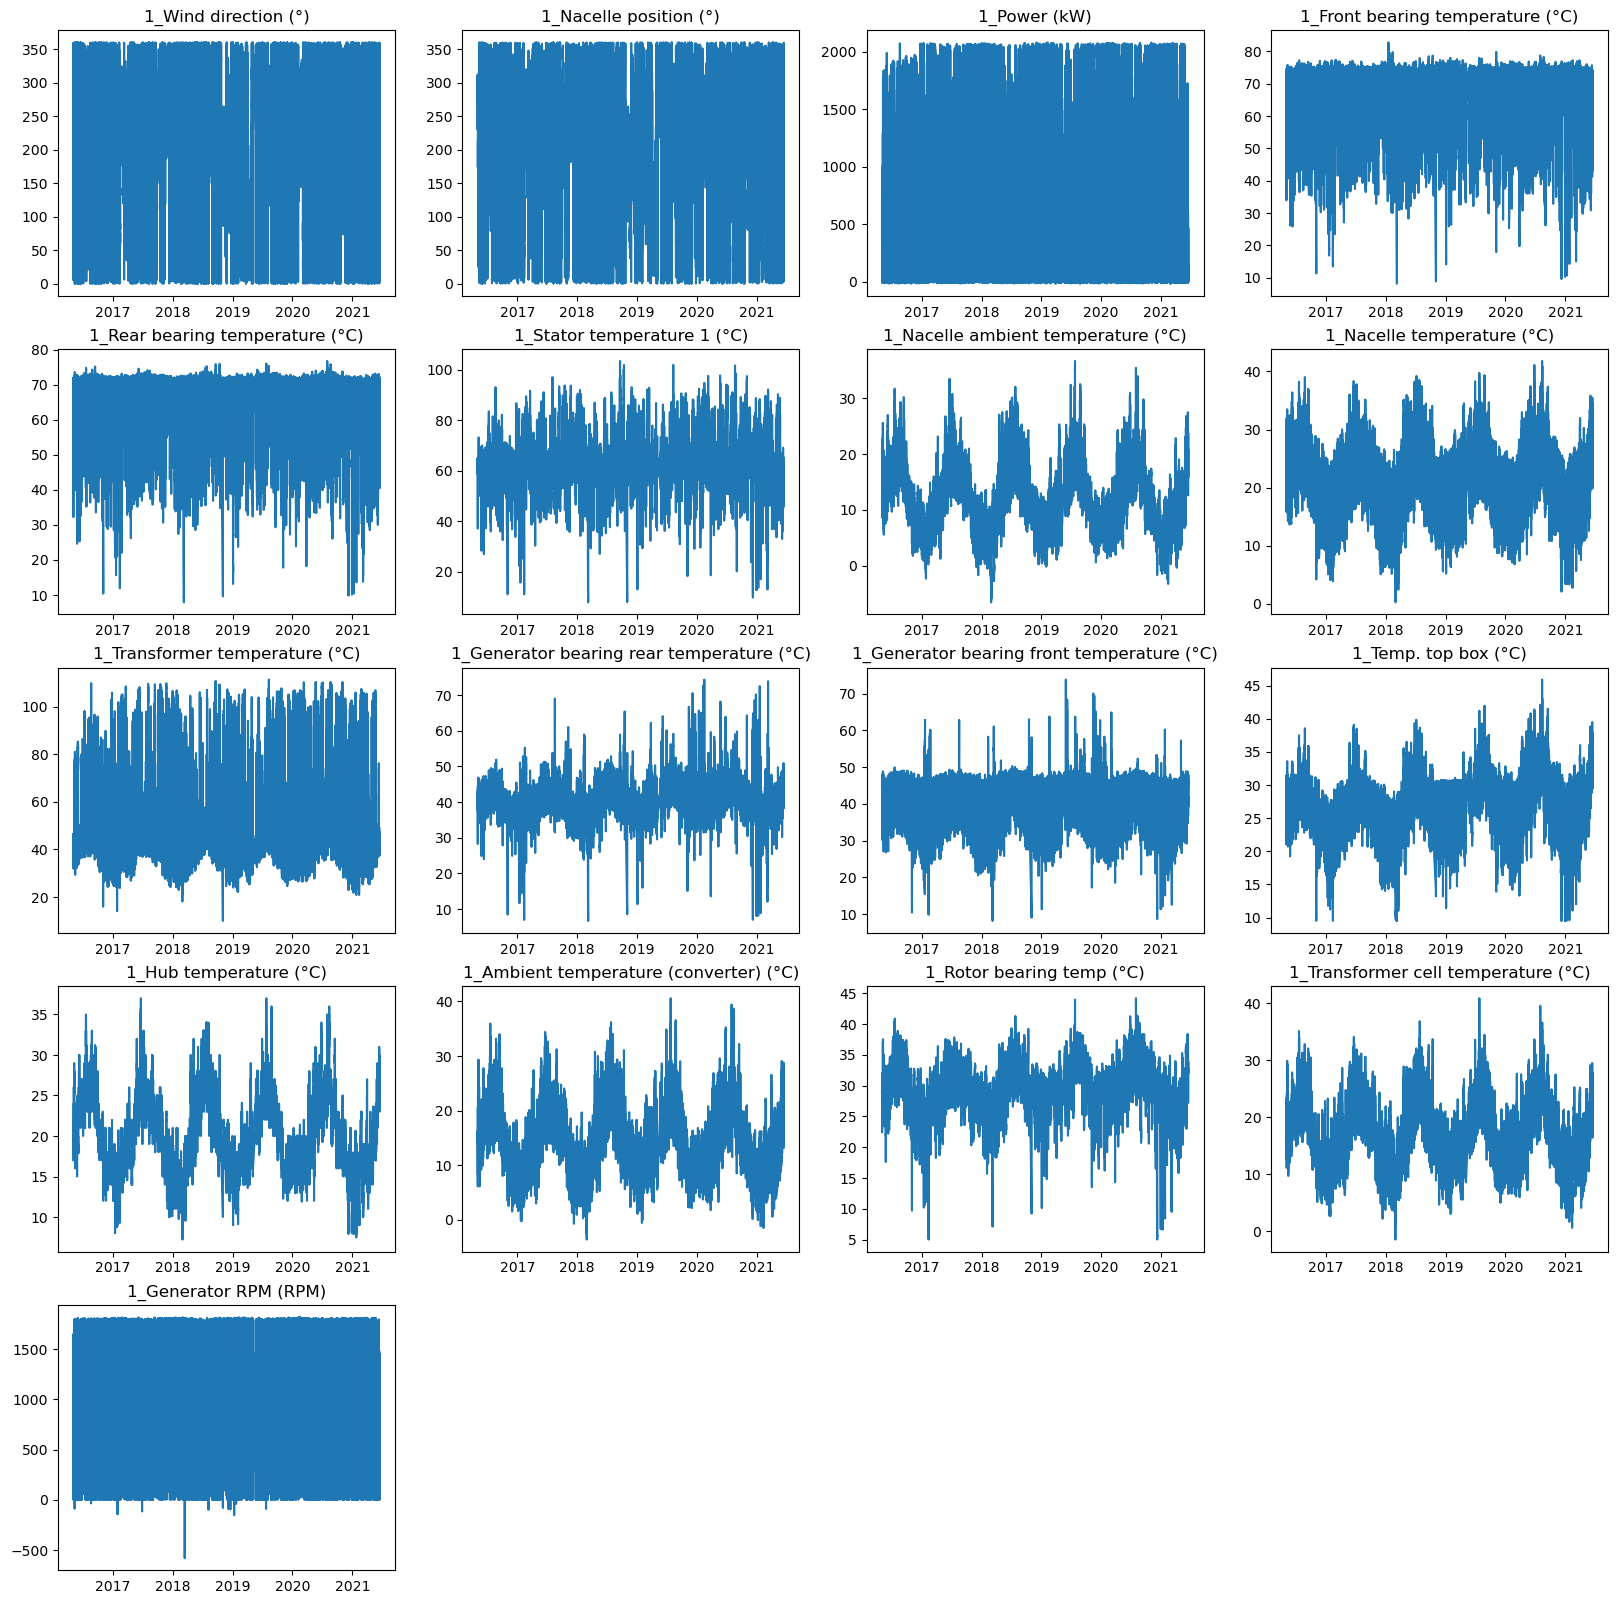

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

original_cols = ['1_Wind direction (°)',
       '1_Nacelle position (°)', '1_Power (kW)',
       '1_Front bearing temperature (°C)', '1_Rear bearing temperature (°C)',
       '1_Stator temperature 1 (°C)', '1_Nacelle ambient temperature (°C)',
       '1_Nacelle temperature (°C)', '1_Transformer temperature (°C)',
       '1_Generator bearing rear temperature (°C)',
       '1_Generator bearing front temperature (°C)', '1_Temp. top box (°C)',
       '1_Hub temperature (°C)', '1_Ambient temperature (converter) (°C)',
       '1_Rotor bearing temp (°C)', '1_Transformer cell temperature (°C)', '1_Generator RPM (RPM)']

X_train = pd.read_csv('data/single_turbine_data/X_train.csv')
X_test = pd.read_csv('data/single_turbine_data/X_test.csv')
data = pd.read_csv('data/evaluation_data/X_single_turbine.csv')
all_data = pd.concat([X_train, X_test, data])
all_data['# Date and time'] = pd.to_datetime(all_data['# Date and time'])
all_data.set_index('# Date and time', inplace=True)

# create subplot for each column
plt.figure(figsize=(20, 20))

for col in original_cols:
       plt.subplot(5, 4, original_cols.index(col)+1)
       plt.plot(all_data[col])
       plt.title(col)

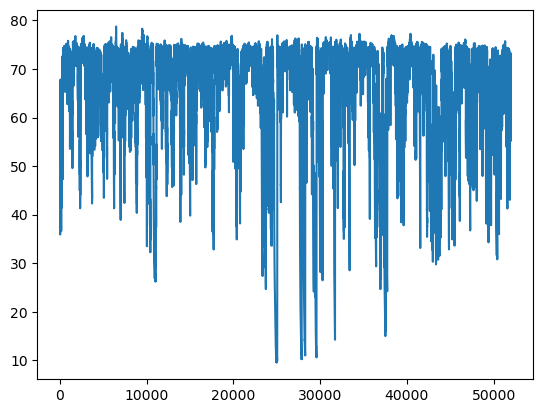

In [4]:
plt.plot(range(len(data)), data['1_Front bearing temperature (°C)'])